In [1]:
import sys  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib as mpl

sys.path.insert(0, '../../')
from mystatlearn.interpolation import CubicSpline

%matplotlib inline
%load_ext autoreload
%autoreload 2
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
rcParams = {
    'font.family' : 'Latin Modern Math',
    'font.size': 12,
    'axes.linewidth' : 1.5,
    'mathtext.fontset' : 'stix'
}
mpl.rcParams.update(rcParams)

# Natural Cubic Splines

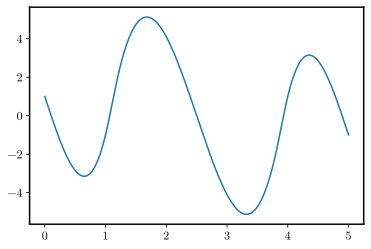

In [334]:
X = np.array([0, 1, 1.2, 3.8, 4, 5]).astype('float32')
y = np.array([1, -1, 2, -2, 1, -1]).astype('float32')

spline = CubicSpline()
spline.fit(X, y)

xs = np.linspace(0, 5, 1000)
y_fit = spline.predict(xs)
plt.plot(xs, y_fit)

In [302]:
def compute_params(X, y):
    n = len(X) - 1
    a = y
    b = np.zeros(n)
    d = np.zeros(n)
    h = X[1: ] - X[:-1]
    alpha = np.zeros(n)
    alpha[1:] = (
        (3 / h[1:])  * (a[2:] - a[1:-1]) 
        - (3 / h[:-1])  * (a[1:-1] - a[:-2])
    )
    c = np.zeros(n + 1)
    l = np.zeros(n + 1)
    mu = np.zeros(n + 1)
    z = np.zeros(n + 1)
    l[0] =  1
    for i in range(1, n):
        l[i] = 2 * (X[i + 1] - X[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i - 1] * z[i - 1]) / l[i]
    l[n] = 1
    c[n] = z[n] = 0
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - mu[j] * c[j + 1]
        b[j] = (
            (a[j + 1] - a[j]) / h[j] 
            - (h[j] * (c[j + 1] + 2 * c[j])) / 3
        )
        d[j] = (c[j+ 1] - c[j]) / (3 * h[j])
    return a, b, c, d

def get_j_spline(x, j, X, a, b, c, d):
    S = (
        a[j] + b[j] * (x - X[j]) + c[j] * (x - X[j]) ** 2 
        + d[j] * (x - X[j]) ** 3
    )
    return S

def get_spline(x, X, a, b, c, d):
    for j in range(0, len(X) - 1):
        if (X[j] <= x) and (x < X[j + 1]):
            return get_j_spline(x, j, X, a, b, c, d)

def fit_spline(X, y):

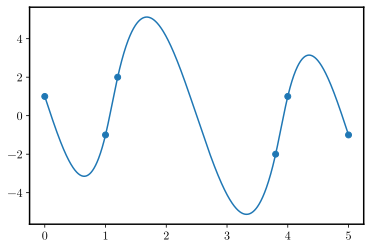

In [312]:
X = np.array([0, 1, 1.2, 3.8, 4, 5]).astype('float32')
y = np.array([1, -1, 2, -2, 1, -1]).astype('float32')

a, b, c, d = compute_params(X, y)
xs = np.linspace(0, 5, 1000)
plt.scatter(X, y)
plt.plot(xs, [get_spline(x, X, a, b, c, d) for x in xs])

In [185]:
def divided_difference(x, y):
    if x.size > 1:
        b = divided_difference(x[1: ], y[1: ])
        a = divided_difference(x[:-1], y[:-1])
        return (b - a) / (x[-1] - x[0])
    else:
        return y

divided_difference(np.array([0, 1, 2]), np.array([2, 5, 2]))

array([3.])

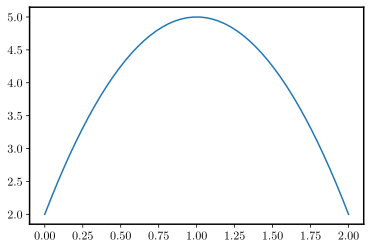

In [186]:
plt.plot(np.linspace(0, 2), [2 + 3*x - 3*(x)*(x-1) for x in np.linspace(0, 2)])

In [205]:
def first_divided_difference(x, y):
    return (
        y[0] / (x[0] - x[1])
        + y[1] / (x[1] - x[0])
    )

def second_divided_difference(x, y):
    return (
        y[0] / ((x[0] - x[1]) * (x[0] - x[2]))
        + y[1] / ((x[1] - x[0]) * (x[1] - x[2]))
        + y[2] / ((x[2] - x[0]) * (x[2] - x[1]))
    )

In [282]:
X = np.array([0, 1, 2, 3, 4, 5]).astype('float32')
y = np.array([0, 1, 2, 3, 4, 5]).astype('float32')


h = np.diff(X)
mu = np.zeros(n)
l = np.zeros(n)
mu[:-1] = h[:-1] / (h[:-1] + h[1:])
l[1:] = 1 - mu[:-1]
n = len(X) - 1
d = np.zeros(n + 1)
d[0] = 6 * first_divided_difference(X[:2], y[:2])
for i in range(1, n):
    d[i] = 6 * second_divided_difference(X[i-1:i+2], y[i-1:i+2])
d[n] = 6 * first_divided_difference(X[-2:], y[-2:])
mu[-1] = 1
l[0] = 1

L = np.eye(n + 1) * 2
for i in range(1, n + 1):
    L[i, i - 1] = mu[i - 1]
    L[i - 1, i] = l[i - 1]

M = np.linalg.solve(L, d)

In [283]:
def get_i_spline(x, i, X, y, M, h):
    return (
        M[i - 1] * (X[i] - x)**3 / (6 * h[i])
        + M[i] * (x - X[i- 1])**3 / (6 * h[i])
        + (y[i - 1] - ((M[i -1]*h[i]**2) / 6)) * (X[i] - x) / h[i]
        + (y[i] - ((M[i]*h[i]**2) / 6)) * (x - X[i - 1]) / h[i]
    )

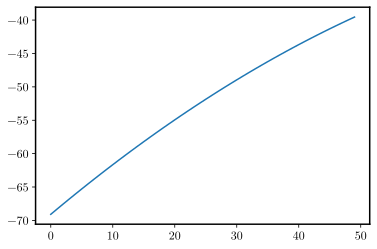

In [284]:
plt.plot([get_i_spline(x, 0, X, y, M, h) for x in np.linspace(0, 1)])

In [274]:
M

array([-11.96172249,  11.92344498, -11.73205742,  11.00478469,
        -8.28708134,  -1.85645933])

In [232]:
n

5